# Multiple fields of Crop Biomass through Planet subscriptions API
In the Crop_Biomass_Example.ipynb Jupyter Notebook we show how you can create subscription for the Crop Biomass Planetary Variable in a single field and we visualize it's outputs. In practice, however, one often wants to create a subscription for multiple fields. In this notebook we show how you can create such a subscription and analyze its data. 

For more information on working with Planetary Variables in the Subscriptions API, see:
- 📚 [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/)
- 📚 [Crop Biomass specifications](https://developers.planet.com/docs/planetary-variables/crop-biomass/)

## Before you start
To be able to run this code, you will need:
1. 🔑 A Planet API key. See: [Find Your API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
2. 📦 A (virtual) environment with a recent (>= 3.8) Python installation and the following packages:
   - [Planet SDK for Python](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/#step-1-install-python-37-and-a-virtual-environment)
   - [matplotlib](https://matplotlib.org/)
   - [rioxarray](https://corteva.github.io/rioxarray/html/installation.html)
3. 🌍 Access to the `BIOMASS-PROXY_V4.0_10` product.
4. (Optional) Configured credentials for a cloud storage provider (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite).

Below you will find a workflow to subscribe and retrieve Crop Biomass data for three fields in the Netherlands. We will show how to deliver raster/GeoTIFF data to the Google Cloud Platform (GCP) and how this data can be visualized. You can adjust the code to use your chosen cloud storage provider as required, but you can also choose to not specify the delivery parameter, if you are only interested in time series data. Check our Crop_Biomass_Example.ipynb Jupyter Notebook to access the data after creating 

ℹ️ The notebook is written for Python 3.8 or greater and is based on the Planet Software Development Kit ([Planet SDK documentation](https://planet-sdk-for-python-v2.readthedocs.io)).

## Getting the data
First we import the required libraries:

In [1]:
import base64
import datetime as dt
import json
from getpass import getpass
from io import StringIO

import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rioxarray as rx
from planet import Auth, Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import build_request, planetary_variable_source

### Credentials
The next step is to [Authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored securely for making the subsequent calls to the Subscriptions API.

In [2]:
api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

### Define your Area of Interest (AOI)
In your [Planet account dashboard](https://www.planet.com/account/#/dashboard), you can check your provisioned data - for this walkthrough, you will need to have access to the Crop Biomass data product. 

💡 **Tip:** There are several options to define your AOI. In this example we manually added the JSON for three fields in the Netherlands, but you can also draw and copy a geometry using online tools such as the [SentinelHub EO-browser](https://apps.sentinel-hub.com/eo-browser/) or [GeoJSON.io](https://geojson.io/#map=2/0/20). Similarly, you can use Planet's [features manager](https://developers.planet.com/docs/apps/features-manager/) to create a feature and add provide it's URI (Uniform Resource Identifier) as the AOI variable in the code below (some examples of public features are provided [here](https://www.planet.com/features/?org=1&loc=0,0,2.86z)).

In [3]:
AOI = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "id": 1,
        "name": "Field 1"
      },
      "geometry": { "type": "Polygon", "coordinates": [ [ [ 5.646269457031999, 52.493554381927716 ], [ 5.645532891895269, 52.494197469887212 ], [ 5.645439220109795, 52.494370321019218 ], [ 5.645478290795952, 52.494493623197179 ], [ 5.648445497527954, 52.495682770434797 ], [ 5.648614051003682, 52.495667809889248 ], [ 5.648754526574847, 52.495596110736351 ], [ 5.650409114712862, 52.494141637981123 ], [ 5.650496185872923, 52.494019593365927 ], [ 5.650481147741496, 52.493903557056754 ], [ 5.650378970773897, 52.493820727361523 ], [ 5.647762543667596, 52.49261912469634 ], [ 5.647575303282869, 52.492569326756822 ], [ 5.647404386160223, 52.492584460465736 ], [ 5.647250025586343, 52.492663184807974 ], [ 5.646269457031999, 52.493554381927716 ] ] ] }
    },
    {
      "type": "Feature",
      "properties": {
        "id": 2,
        "name": "Field 2"
      },
      "geometry": { "type": "Polygon", "coordinates": [ [ [ 5.643528242856149, 52.496048201901779 ], [ 5.643350327775964, 52.496260871135306 ], [ 5.64337420201234, 52.496361280598414 ], [ 5.643463679806238, 52.496436040144005 ], [ 5.646301974329031, 52.497604515126326 ], [ 5.646508114716511, 52.497646001419383 ], [ 5.646666200706048, 52.497603329169024 ], [ 5.646788285847359, 52.497519629492722 ], [ 5.647767442159013, 52.496613185641117 ], [ 5.648261233493957, 52.496122269510522 ], [ 5.648331424580856, 52.495996931756267 ], [ 5.648298401392186, 52.495917758443618 ], [ 5.648165016001489, 52.495824556695631 ], [ 5.645658186709922, 52.494764764593924 ], [ 5.645388872808486, 52.494589945069556 ], [ 5.645291625330387, 52.494578190806742 ], [ 5.645091997086596, 52.494629188728297 ], [ 5.644949787830345, 52.494731460859391 ], [ 5.643528242856149, 52.496048201901779 ] ] ] }
    },
    {
      "type": "Feature",
      "properties": {
        "id": 3,
        "name": "Field 3"
      },
      "geometry": { "type": "Polygon", "coordinates": [ [ [ 5.642714083026372, 52.496907814885539 ], [ 5.641352450867375, 52.498186395892901 ], [ 5.641281224332479, 52.49828573376881 ], [ 5.641290967615189, 52.498386807096608 ], [ 5.641455519049732, 52.498504427644704 ], [ 5.644020665209007, 52.499511812082261 ], [ 5.644258207055869, 52.499577207374621 ], [ 5.644427418493609, 52.499569027305789 ], [ 5.644692243237825, 52.499415082212444 ], [ 5.645558964687294, 52.498504472008328 ], [ 5.646196567923609, 52.497967291764326 ], [ 5.646257172885682, 52.497867730303682 ], [ 5.646243223826931, 52.497767180108077 ], [ 5.646051812349505, 52.497639275646385 ], [ 5.643363692498375, 52.496549955562195 ], [ 5.643199364761655, 52.496534113409957 ], [ 5.643069335917217, 52.496570436719495 ], [ 5.642714083026372, 52.496907814885539 ] ] ] }
    }
  ]
}


Optionally, you can also load your geometry from a .geojson file 

In [ ]:
# Get the geometry from a geojson file
fname="my_geometry.geojson"
with open(fname, "r") as file:
    geojson_data = json.load(file)
AOI = geojson_data["features"][0]

Next, we store our field geometries into a pandas DataFrame. This allows for easy storage and monitoring of our uuid's and processing status.

In [4]:
# Extract data
data = []
for feature in AOI['features']:
    properties = feature['properties']
    data.append({
        'id': properties['id'],
        'uuid': None,
        'status': "to_process",
        'name': properties['name'],
        'geometry_json': feature['geometry'],
    })

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df.head()

,id,uuid,status,name,geometry_json
0,1,None,to_process,Field 1,"{'type': 'Polygon', 'coordinates': [[[5.646269..."
1,2,None,to_process,Field 2,"{'type': 'Polygon', 'coordinates': [[[5.643528..."
2,3,None,to_process,Field 3,"{'type': 'Polygon', 'coordinates': [[[5.642714..."


### Define Cloud Storage delivery
In this example, we want to deliver our data directly to a Google Cloud Storage bucket. Below we specify the delivery location and provide our authentication credentials.These credentials will require read/write permissions on the specified bucket. See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key with the appropriate permissions. When using AWS, Azure or OCS, use the corresponding credentials for those platforms.

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) to review the configuration options for different cloud storage providers. This example uses Google Cloud Storage.


In [5]:
# Only for Cloud Storage Delivery
bucket_name="<YOUR BUCKET NAME>"
GOOGLE_APPLICATION_CREDENTIALS="~/.config/gcloud/application_default_credentials.json" # Adjust to your json file location for a GCP service account key with Cloud Storage permission

# Credentials are expected in base64 format -the following reads the json key as bytes,
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

# Your GCP bucket and credentials to save rasters
delivery_config_gcp = {
    "type": "google_cloud_storage",
    "parameters": {
        "bucket": bucket_name,
        "credentials": gcs_credentials_base64,
    }
}

# If you do not want a cloud storage delivery, specify the delivery_config as an empty dict
# delivery_config_gcp = {}

## Define and create your subscription(s)
Now that everything has been set up we will create a subcription for each of the individual fields. In the cell below we iterate over each row (field) in the DataFrame, create and post a subscription object for it and update the 'uuid' and 'status' of this subscription (note how the DataFrame changes). In case the subscription fails for some reason, you can re-run the cell and only that specific subscription will be recreated. 

In [6]:

for row, items in df.iterrows(): 
    
    if df.loc[row, 'status'] == "to_process" or df.loc[row, 'status'] == "failed":
        
        pv_source = planetary_variable_source(
            var_type='biomass_proxy',
            var_id="BIOMASS-PROXY_V4.0_10", 
            geometry=df.loc[row, "geometry_json"], 
            start_time=dt.datetime(2020, 1, 1),
            end_time=dt.datetime(2023, 12, 31)
        )

        subscription_name = f"CB_{df.loc[row, "name"]}"
        request = build_request(subscription_name, source=pv_source, delivery=delivery_config_gcp)
        
        try:
            async with Session(auth=auth) as sess:
                cl = SubscriptionsClient(sess)
                subscription_desc = await cl.create_subscription(request)
            df.loc[row, 'uuid']=subscription_desc['id']
            df.loc[row, 'status']=subscription_desc['status']
            print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

        except Exception as e:
            print(f"Failed to create subscription for field: '{df.loc[row, 'name']}', with message: {e}")
            df.loc[row, 'uuid']="failed"
        
    else:
        print(f"Subscription for {df.loc[row, 'name']} already exists, with uuid: {df.loc[row, 'uuid']}")

df.head()


67aedcf3-f8d7-4594-8a40-7561a05fa9f6 named CB_Field 1 created
f2422e0c-b868-4283-8a2c-d6509753e437 named CB_Field 2 created
8c9b94a5-6038-41b6-ac1d-d4ae182a6d7a named CB_Field 3 created


,id,uuid,status,name,geometry_json
0,1,67aedcf3-f8d7-4594-8a40-7561a05fa9f6,preparing,Field 1,"{'type': 'Polygon', 'coordinates': [[[5.646269..."
1,2,f2422e0c-b868-4283-8a2c-d6509753e437,preparing,Field 2,"{'type': 'Polygon', 'coordinates': [[[5.643528..."
2,3,8c9b94a5-6038-41b6-ac1d-d4ae182a6d7a,preparing,Field 3,"{'type': 'Polygon', 'coordinates': [[[5.642714..."


### Monitor the subscriptions
We can monitor each subscription using the cell below, with the [get_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_subscription) method. The subscription status is printed below, but it's status is also updated in the DataFrame (subscription status is explained by [https://developers.planet.com/docs/subscriptions/](https://developers.planet.com/docs/subscriptions/#subscription-status))

In [23]:
for row, items in df.iterrows(): 

    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        subscription_desc = await cl.get_subscription(subscription_id=df.loc[row, 'uuid'])
        
    df.loc[row, 'status']=subscription_desc['status']
    print(f"{subscription_desc['id']} named {subscription_desc['name']} is {subscription_desc['status']}")


67aedcf3-f8d7-4594-8a40-7561a05fa9f6 named CB_Field 1 is completed
f2422e0c-b868-4283-8a2c-d6509753e437 named CB_Field 2 is completed
8c9b94a5-6038-41b6-ac1d-d4ae182a6d7a named CB_Field 3 is completed


### Retrieve the data
We can start retrieving the subscription data even if the status is 'running'. The timeseries results generated for this subscription is retrieved directly in CSV format with `get_results_csv`. We can use the Pandas library to read this into a DataFrame to perform further analysis and to create a nice time series visualization. Since our subscription contains multiple fields, we will concatenate the field data into a single dataframe, using the uuid as identifier.

💡 Read more about the different state of [Subscription Status](https://developers.planet.com/docs/subscriptions/#subscription-status) or the valid_percent in [Metadata Results (Time Series)](https://static.prod.planet-labs.com/devcenter/dev/rel-pv-eap/docs/subscriptions/pvs-subs/#metadata-results-time-series).

In [24]:
data_df = pd.DataFrame()

for row, items in df.iterrows():
    
    async with Session(auth=auth) as sess:
        cl = SubscriptionsClient(sess)
        results_desc = cl.get_results_csv(subscription_id=df.loc[row, 'uuid'])
        results_desc_list = [i async for i in results_desc]

    try:
        row_data = pd.read_csv(StringIO("\n".join(results_desc_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time")
        row_data["uuid"] = df.loc[row, "uuid"]
        row_data["name"] = df.loc[row, "name"]
        data_df = pd.concat([data_df, row_data])
    except:
        print(f"No data found (yet) for field: '{df.loc[row, 'name']}'")


data_df.reset_index(inplace=True)
data_df.set_index('item_datetime', inplace=True)
data_df.sort_index(inplace=True)


## Visualizing the data
If the previous steps are completed, we can visualize the data. In this example we will create (1) a timeseries of annual mean crop biomass per field and (2) a visualization of the crop biomass in a raster for each of the fields, on three different dates.

### Timeseries
Now that we have the timeseries data in a Pandas DataFrame, we can visualize it. But first we will filter out invalid results, by removing null values and crop biomass values below 0. Since the subscription might still be running, we also remove the `QUEUED` items.

In [25]:
# Filter by valid data only
data_df = data_df[data_df["CB.band-1.valid_percent"].notnull()]
data_df = data_df[data_df["CB.band-1.valid_percent"] > 0]
data_df = data_df[data_df["status"] != 'QUEUED']

Next, we calculate the daily crop biomass and visualize the values over time. 

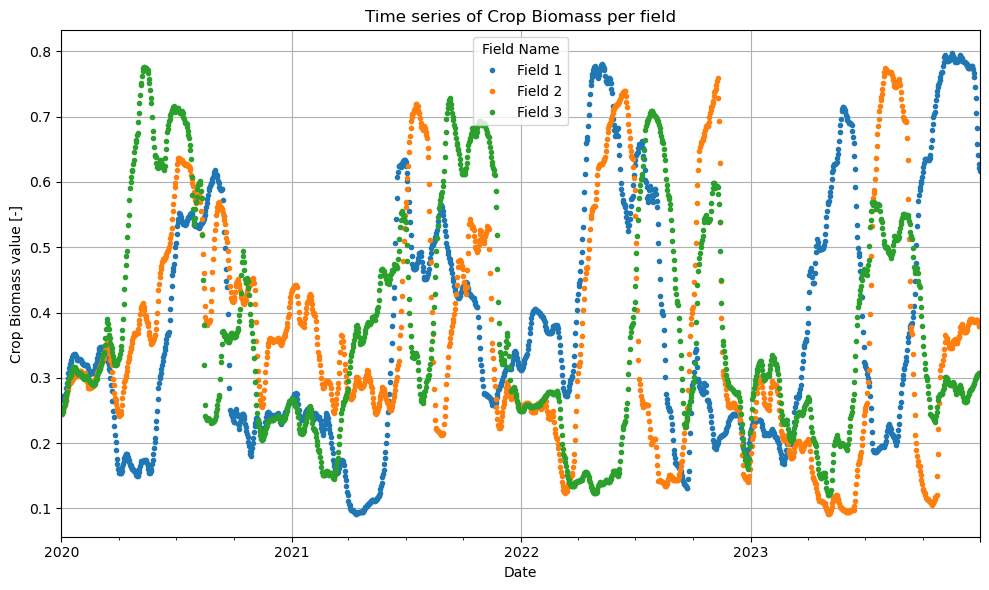

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
for field in data_df.groupby("name"):
    field[1]['CB.band-1.mean'].plot(ax=ax, kind='line', style='o', label=field[0], markersize=3)

ax.set_xlabel('Date')
ax.set_ylabel('Crop Biomass value [-]')
ax.set_title('Time series of Crop Biomass per field')
ax.grid(True)
ax.legend(title='Field Name')
fig.tight_layout()

### Rasters
Next, we will visualize the GeoTIFF data as well. In the cell below we will plot the rasters of the three fields at three different dates. In this example we chose the first of April, June and August 2022, as they roughly correspond to a peak in biomass in each of the three fields, as derived from our timeseries. For the plotting we use the rioxarray extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) as it can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

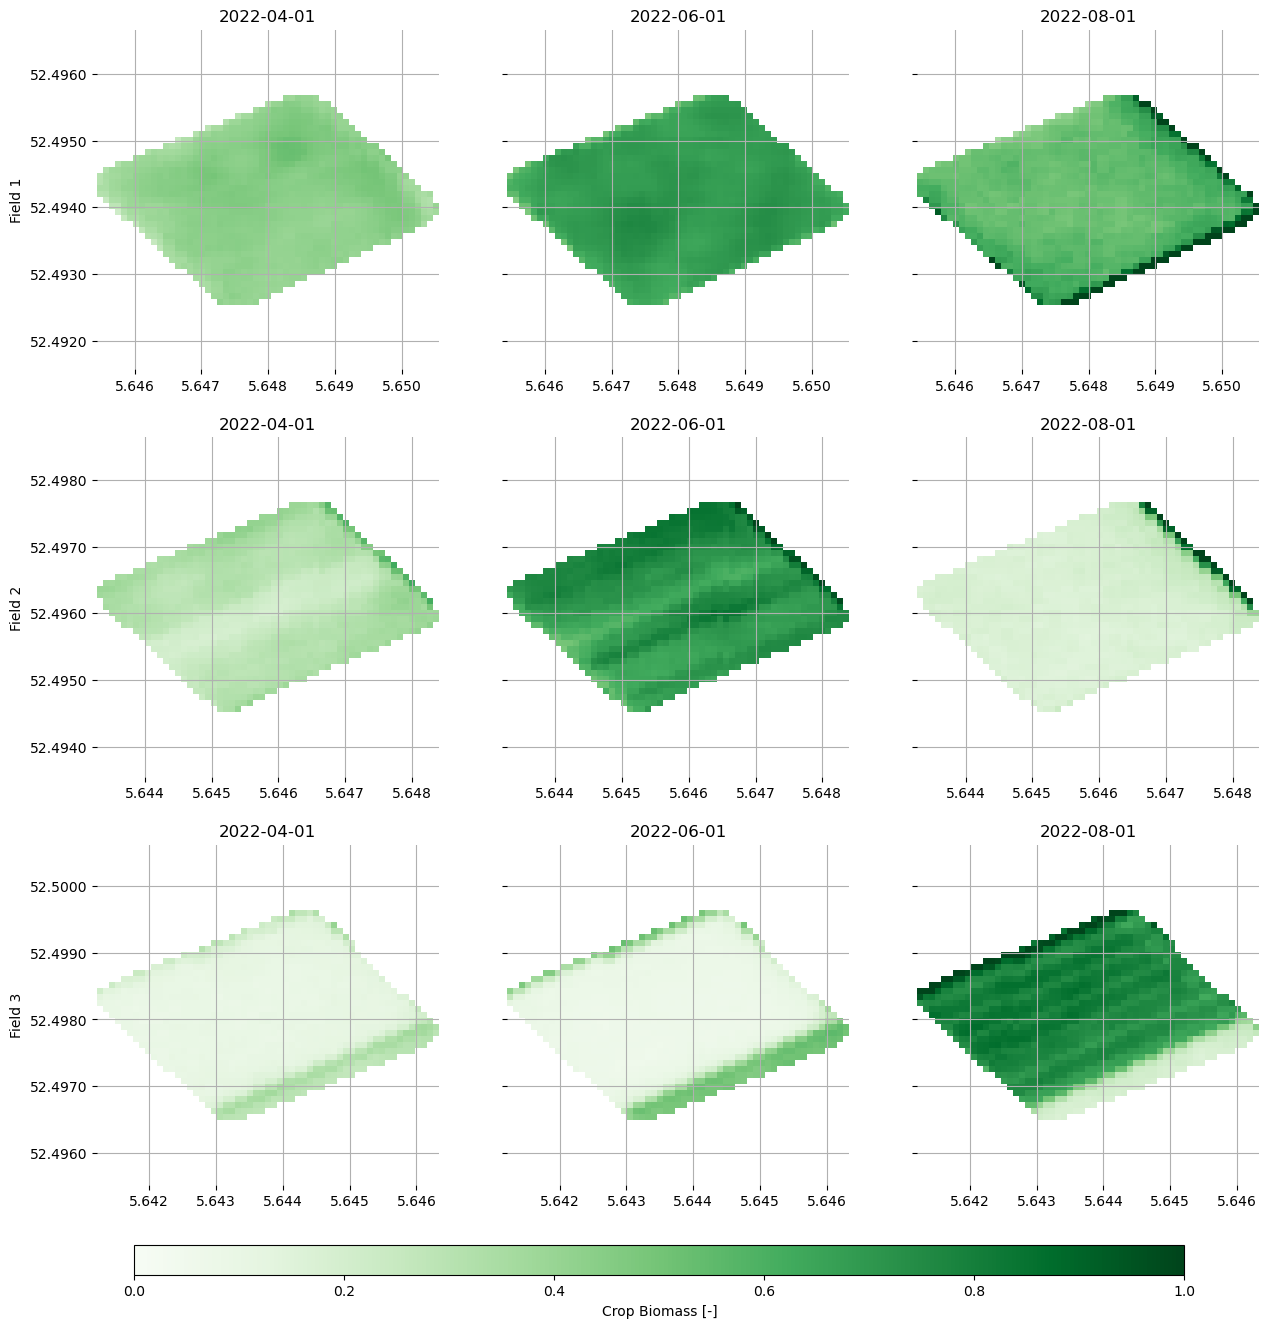

In [38]:
dates_to_plot = ["2022-04-01", "2022-06-01", "2022-08-01"]

# Create a dictionary to map uuid to field name, and sort the uuids by alphabetical order of the field names
uuid_to_name = data_df.set_index('uuid')['name'].to_dict()
sorted_uuids = sorted(pd.unique(data_df["uuid"]), key=lambda x: uuid_to_name[x])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for j, field in enumerate(sorted_uuids):
    for i, date in enumerate(dates_to_plot):
    
        file = f"gs://{bucket_name}/{field}/{date.replace('-','/')}/BIOMASS-PROXY_V4.0_10-{date.replace('-','')}T0000_CB.tiff"
        field_name = uuid_to_name[field]

        with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
            cb_data = rx.open_rasterio(file, mask_and_scale=True, band_as_variable=True)

            cb_data = cb_data.rename_vars({
                "band_1":"Crop Biomass [-]",
            })

            img = cb_data["Crop Biomass [-]"].plot(ax=ax[j, i], cmap="Greens", vmin=0, vmax=1, add_colorbar=False)
        
        ax[j, i].set_title(f"{date}")
        ax[j, i].grid(True)
        ax[j, i].axis("equal")
        ax[j, i].set_xlabel("")
        ax[j, i].set_ylabel("")
        ax[j, 0].set_ylabel(field_name)
        ax[j, i].set_frame_on(False)
    
    ax[j, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))
    ax[j, 1].set_yticklabels([])
    ax[j, 2].set_yticklabels([])
    
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Crop Biomass [-]')

plt.show()